In [3]:
import pandas as pd



In [4]:
df = pd.read_csv("../datas/interim/matched_edits_all.csv")


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45697 entries, 0 to 45696
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   article                               45697 non-null  object 
 1   user                                  45697 non-null  object 
 2   date                                  45697 non-null  object 
 3   comment                               37473 non-null  object 
 4   llm_output                            45697 non-null  object 
 5   weaponised                            45697 non-null  object 
 6   ngram                                 45697 non-null  object 
 7   df_index                              45697 non-null  int64  
 8   row_index_matched                     45697 non-null  int64  
 9   fg_row_index                          45697 non-null  int64  
 10  detected_before                       45697 non-null  object 
 11  detected_after 

In [6]:
print(df["user"].nunique(), "unique users found")
print(df["user"].value_counts().head(10))  # Top users by edit count

2454 unique users found
user
LSGH                   2385
TheDraperyFalls        2118
Toddy1                 1705
Genyo                  1377
UP9                    1214
Aleksandr Grigoryev    1066
Euroserhi               923
Dbachmann               915
Vasile                  908
Irpen                   773
Name: count, dtype: int64


## Articles we are dealing with

It seems that in the 41 unique article found, none are from the full scale Russia invasion in Ukraine.

In [8]:
print(df['article'].nunique(), "unique article found") 
print(df["article"].value_counts())

41 unique article found
article
COVID-19_pandemic_in_Ukraine_analysis                              12517
History_of_Ukraine_analysis                                        11469
Crimea_analysis                                                     9137
Annexation_of_Crimea_by_the_Russian_Federation_analysis             2103
Football_in_Ukraine_analysis                                        2034
Bukovina_analysis                                                   1513
2004_Ukrainian_presidential_election_analysis                       1380
English_Civil_War_analysis                                           853
2014_pro-Russian_unrest_in_Ukraine_analysis                          726
Bessarabia_analysis                                                  671
Alexander_II_of_Russia_analysis                                      506
Christmas_in_Ukraine_analysis                                        452
History_of_Christianity_in_Ukraine_analysis                          432
Christianity_in_Rus

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

df["year"] = pd.to_datetime(df["date"], errors="coerce").dt.year

# Drop the rows without valid year or weaponised label..
df = df.dropna(subset=["year", "weaponised"])

# Ensure correct types
df["year"] = df["year"].astype(int)

# Normalizing the weaponised field because there are some capitalised and soem not --> lowercase and strip
df["weaponised"] = df["weaponised"].astype(str).str.strip().str.lower()
df["weaponised"] = df["weaponised"].replace({
    "true": "Weaponised",
    "false": "Not Weaponised",
    "unknown": "Unknown",
    "weaponised": "Weaponised",
    "not weaponised": "Not Weaponised"
})

df["weaponised"].unique()

array(['Not Weaponised', 'Weaponised', 'Unknown'], dtype=object)

In [17]:
all_users_datas = {
    # Basic metrics
    "total_edits": len(df),
    "total_users": df["user"].nunique(),
    "number_of_unique_articles": df["article"].nunique(),

    # User type breakdown
    "num_bot_users": df[df["is_bot"]]["user"].nunique(),
    "num_anonymous_users": df[df["is_anon"]]["user"].nunique(),
    "num_registered_users": df[~df["is_bot"] & ~df["is_anon"]]["user"].nunique(),

    # Edit breakdown by type
    "num_bot_edits": df["is_bot"].sum(),
    "num_anonymous_edits": df["is_anon"].sum(),
    "num_registered_edits": len(df) - (df["is_bot"].sum() + df["is_anon"].sum()),

    # Weaponisation classification
    "weaponised_edits": df["weaponised"].sum() if "weaponised" in df.columns else None,
    "non_weaponised_edits": len(df) - df["weaponised"].sum() if "weaponised" in df.columns else None,
}

TypeError: unsupported operand type(s) for -: 'int' and 'str'

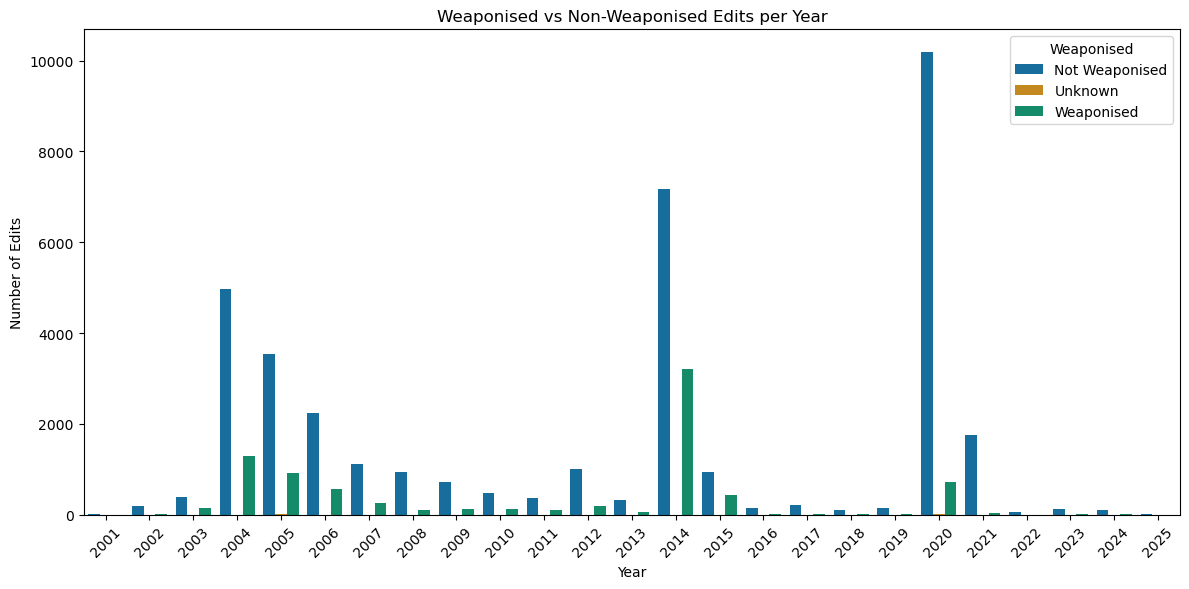

In [11]:
df_counts = df.groupby(["year", "weaponised"]).size().reset_index(name="count")

sns.set_palette("colorblind")
plt.figure(figsize=(12, 6))
sns.barplot(data=df_counts, x="year", y="count", hue="weaponised")

plt.title("Weaponised vs Non-Weaponised Edits per Year")
plt.xlabel("Year")
plt.ylabel("Number of Edits")
plt.legend(title="Weaponised")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
top_users = (
    df[df["comment"].notna()]
    .groupby("user")
    .size()
    .sort_values(ascending=False)
    .head(10)
    .index
)
top_users = list(top_users)
top_users

['LSGH',
 'Toddy1',
 'TheDraperyFalls',
 'UP9',
 'Genyo',
 'Aleksandr Grigoryev',
 'Dbachmann',
 'Vasile',
 'Irpen',
 'Mzajac']

In [15]:
# jsut a subset of data for now
df_top = df[df["user"].isin(top_users)]

# count edits per (user, year, weaponised)
grouped = (
    df_top.groupby(["user", "year", "weaponised"])
    .size()
    .reset_index(name="count")
)
grouped

,user,year,weaponised,count
0,Aleksandr Grigoryev,2008,Not Weaponised,19
1,Aleksandr Grigoryev,2008,Weaponised,2
2,Aleksandr Grigoryev,2009,Not Weaponised,164
3,Aleksandr Grigoryev,2009,Weaponised,18
4,Aleksandr Grigoryev,2010,Not Weaponised,108
...,...,...,...,...
70,Vasile,2004,Weaponised,102
71,Vasile,2005,Not Weaponised,144
72,Vasile,2005,Weaponised,43
73,Vasile,2006,Not Weaponised,87


/Users/garambois/miniforge3/envs/ada/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


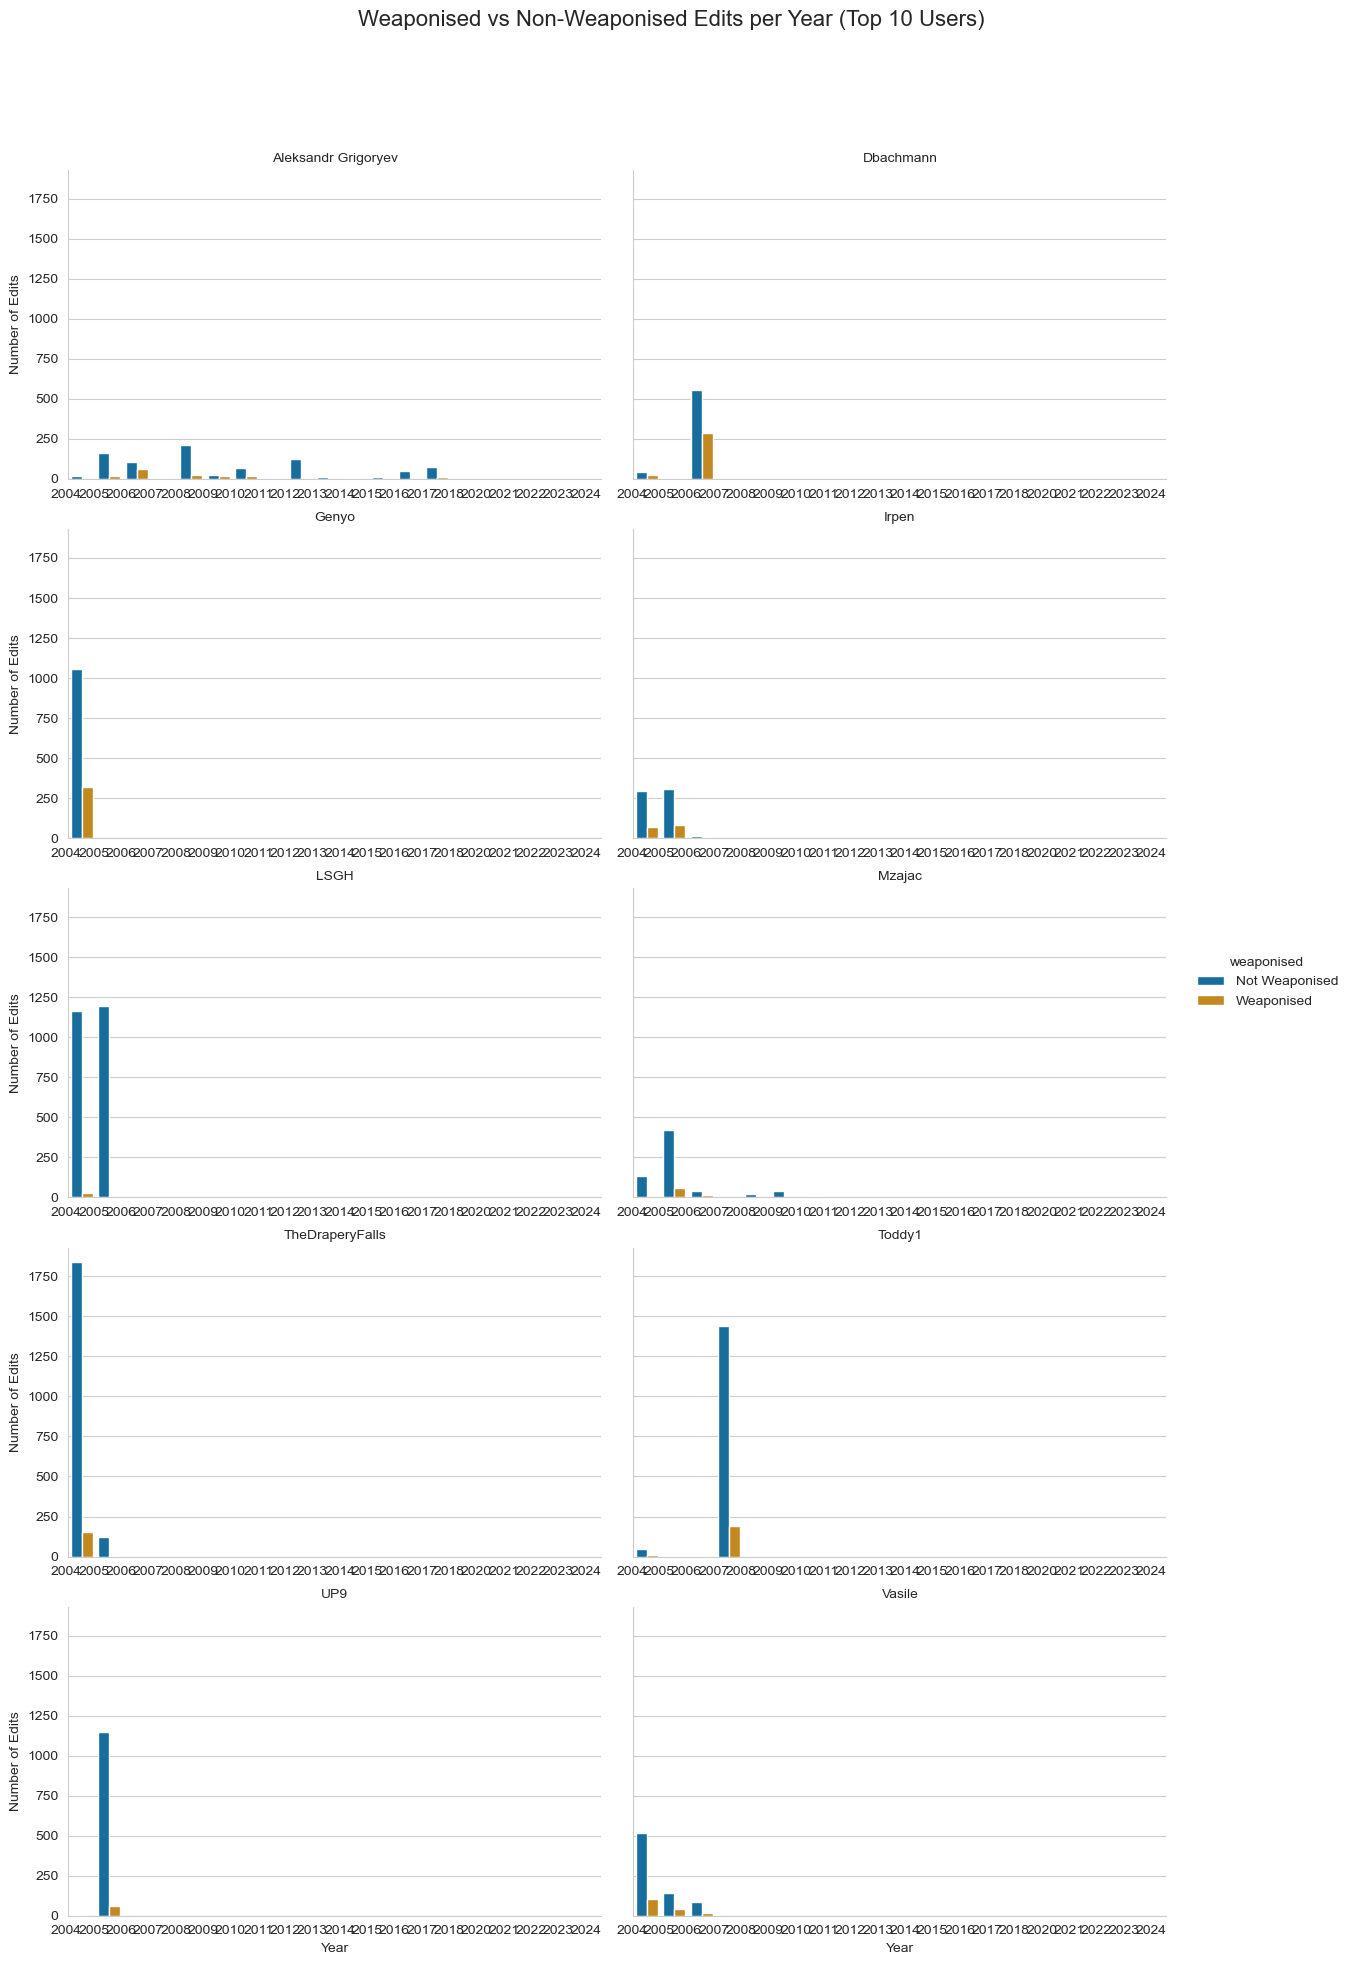

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette("colorblind")
sns.set_style("whitegrid")

grouped["year"] = grouped["year"].astype(str)

# get all years to use for x-axis labels, they are not show by default for some reason
all_years = sorted(grouped["year"].unique())

g = sns.catplot(
    data=grouped,
    kind="bar",
    x="year",
    y="count",
    hue="weaponised",
    col="user",
    col_wrap=2,
    height=4,
    aspect=1.5,
    sharey=True,
    sharex=False
)

g.set_titles("{col_name}")
g.set_axis_labels("Year", "Number of Edits")
g.fig.suptitle("Weaponised vs Non-Weaponised Edits per Year (Top 10 Users)", fontsize=16)

for ax in g.axes.flat:
    ax.set_xticks(range(len(all_years)))
    ax.set_xticklabels(all_years, rotation=00, ha='right')

g.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()